# 1d. Clean survey data in India
India survey data comes from the 2012 SECC, access via SHRUG (https://www.devdatalab.org/shrug)

In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
data_dir = '/data/mosaiks/shrug/'
data_fp = os.path.join(data_dir,'shrug_stats.dta')

data_full = pd.read_stata(data_fp)
all_df = data_full.copy(deep=True)
data_full.head(2)


,shrid,pc11_pca_tot_p,shrid_pc11_pca_tot_p_r,shrid_pc11_pca_tot_p_u,ec13_emp_all,ec13_emp_manuf,secc_cons_pc_rural,secc_pov_rate_rural,secc_pov_rate_urban,secc_cons_pc_urban,viirs_mean_light_2020,dmsp_mean_light_2012
0,11-01-001-00001-000002,3770.0,3770.0,NaN,49.0,0.0,13509.517578,0.477891,NaN,NaN,0.295413,0.0
1,11-01-001-00001-000005,5255.0,5255.0,NaN,82.0,9.0,8611.757812,0.776421,NaN,NaN,0.000000,0.0


In [13]:
# read in shapefiles
shapefile_fp = os.path.join(data_dir,'shrid2.gpkg')
shapefiles_full = gpd.read_file(shapefile_fp)

In [14]:
# remove any with thiessen shapefiles
shps = shapefiles_full[shapefiles_full.polytype != 'thiessen'].copy()
data_with_shps = data_full.merge(shps[['shrid','pc11_id','geometry']],on='shrid', how='inner')
len(data_with_shps)

552290

In [51]:
data_with_shps

,shrid,pc11_pca_tot_p,shrid_pc11_pca_tot_p_r,shrid_pc11_pca_tot_p_u,ec13_emp_all,ec13_emp_manuf,secc_cons_pc_rural,secc_pov_rate_rural,secc_pov_rate_urban,secc_cons_pc_urban,viirs_mean_light_2020,dmsp_mean_light_2012,pc11_id,geometry
0,11-01-001-00001-000002,3770.0,3770.0,NaN,49.0,0.0,13509.517578,0.477891,NaN,NaN,0.295413,0.000000,000002,"POLYGON ((73.83562 34.55965, 73.82536 34.56084..."
1,11-01-001-00001-000005,5255.0,5255.0,NaN,82.0,9.0,8611.757812,0.776421,NaN,NaN,0.000000,0.000000,000005,"POLYGON ((73.94629 34.56991, 73.94711 34.57160..."
2,11-01-001-00001-000006,3001.0,3001.0,NaN,43.0,8.0,9498.938477,0.730325,NaN,NaN,0.000000,0.000000,000006,"POLYGON ((73.99655 34.53958, 73.99404 34.54025..."
3,11-01-001-00001-000007,1310.0,1310.0,NaN,47.0,9.0,11964.706055,0.530650,NaN,NaN,0.000000,0.000000,000007,"POLYGON ((74.04991 34.56041, 74.05875 34.55555..."
4,11-01-001-00001-000008,129.0,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.569642,0.000000,000008,"POLYGON ((74.05124 34.58150, 74.05097 34.58295..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552285,11-34-637-05915-645007,6866.0,6866.0,NaN,1265.0,96.0,24773.896484,0.117859,NaN,NaN,4.213192,33.076923,645007,"POLYGON ((79.78300 10.93428, 79.78519 10.93451..."
552286,11-34-637-05915-645008,2321.0,2321.0,NaN,805.0,662.0,23575.189453,0.138053,NaN,NaN,1.423710,19.562500,645008,"POLYGON ((79.74381 10.92124, 79.74391 10.92200..."
552287,11-34-637-05915-645009,3890.0,3890.0,NaN,566.0,90.0,23443.544922,0.140813,NaN,NaN,0.970596,16.062500,645009,"POLYGON ((79.73190 10.94147, 79.73238 10.93964..."
552288,11-34-637-05915-645010,2482.0,2482.0,NaN,172.0,11.0,20881.154297,0.214994,NaN,NaN,2.153754,23.444445,645010,"POLYGON ((79.77381 10.90571, 79.77368 10.90576..."


#### 1. until paul gets us pc_11_pca_tot_u and pc_11_pca_tot_r, just ignore shrids with both urban and rural

In [17]:
all_df = data_with_shps.dropna(subset=['secc_cons_pc_rural','secc_cons_pc_urban'],how='all').copy()
print(f'{len(data_with_shps) - len(all_df)} entries dropped for not having consumption value')

26422 entries dropped for not having consumption value


In [18]:
all_df.loc[:,'rural'] = all_df['secc_cons_pc_rural'].notna()
all_df.loc[:,'urban'] = all_df['secc_cons_pc_urban'].notna()
print(all_df['rural'].mean())
print(all_df['urban'].mean())
print(all_df['urban'].mean()+all_df['rural'].mean())

0.9935383023876714
0.006701301467288369
1.0002396038549597


#### 1. consumption at shrid unit as weighted average of rural and urban consumption - skip for now

In [19]:
def compute_combined_consumption(secc_pc_df):
    '''Combine consumption between urban and rural based on the census population counts.
    
    Takes an average of the per-capita population consumption for urban and rural from SECC, weighted by 
    urban and rural population counts in the census data.
    
    Inputs: dataframe with SECC and census pc data already merged by shrid
    
    Returns: pd.series of combined per capita consumption 
    '''
    tot_cons_rural = secc_pc_df['secc_cons_pc_rural'].fillna(0) * secc_pc_df['shrid_pc11_pca_tot_p_r'].fillna(0)
    tot_cons_urban = secc_pc_df['secc_cons_pc_urban'].fillna(0) * secc_pc_df['shrid_pc11_pca_tot_p_u'].fillna(0)
    
    # only count population in the denominator if consumption for that type is not nan
    denom_rural = secc_pc_df['shrid_pc11_pca_tot_p_r'].fillna(0)*secc_pc_df['secc_cons_pc_rural'].notna().astype(int)
    denom_urban = secc_pc_df['shrid_pc11_pca_tot_p_u'].fillna(0)*secc_pc_df['secc_cons_pc_urban'].notna().astype(int)

    return (tot_cons_rural + tot_cons_urban) / (denom_rural + denom_urban)

In [20]:
# combine consumption between urban and rural based on the census population counts
all_df['secc_cons_pc_combined'] = compute_combined_consumption(all_df)
# add urban and rural -- it's only going to be different from the existing data for like two rows, and barely

all_df['pc11_pca_tot_p_combined'] = all_df['shrid_pc11_pca_tot_p_u'].fillna(0) + all_df['shrid_pc11_pca_tot_p_r'].fillna(0)
all_df['frac_rural'] =  all_df['shrid_pc11_pca_tot_p_r'].fillna(0) / all_df['pc11_pca_tot_p_combined']
all_df['frac_urban'] =  all_df['shrid_pc11_pca_tot_p_u'].fillna(0) / all_df['pc11_pca_tot_p_combined']
# make sure consumption only different for rows that had consumption values for both urban and rural
num_rows_with_urban_and_rural_secc = ((all_df['secc_cons_pc_rural'].notna().astype(int) + all_df['secc_cons_pc_urban'].notna().astype(int)) > 1).sum()
num_rows_altered_by_combo = len(all_df) - np.isclose(all_df['secc_cons_pc_combined'],
                                                     all_df['secc_cons_pc_rural'].fillna(0) + all_df['secc_cons_pc_urban'].fillna(0)).sum()

assert num_rows_with_urban_and_rural_secc == num_rows_altered_by_combo

In [21]:
all_df['log_secc_cons_pc_combined'] = np.log(1+all_df['secc_cons_pc_combined'])

Text(0, 0.5, 'count (urban)')

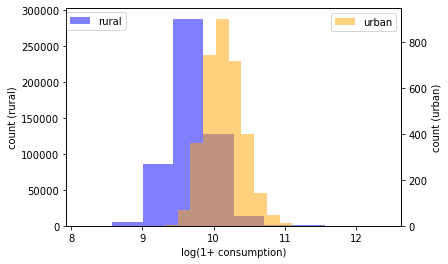

In [22]:
fig, ax = plt.subplots()
ax.hist(all_df[all_df['rural'] == True]['log_secc_cons_pc_combined'], label='rural', 
        color='blue',alpha=.5)
ax2 = ax.twinx()
ax2.hist(all_df[all_df['rural'] == False]['log_secc_cons_pc_combined'], label='urban', 
         color='orange',alpha=.5)
ax.legend(loc=(0,.9))
ax2.legend(loc=0)
ax.set_xlabel('log(1+ consumption)')
ax.set_ylabel('count (rural)')
ax2.set_ylabel('count (urban)')

### Save intermediate csv

In [46]:
all_df['state'] = all_df.apply(lambda x: x.shrid.split('-')[1], axis=1)

In [49]:
all_df['dummy_ones'] = np.ones(len(all_df))

In [ ]:
all_df.to_csv(os.path.join(data_dir,'shrug.csv'))


In [66]:
all_gdf = gpd.GeoDataFrame(all_df)
all_gdf.to_file(os.path.join(data_dir,'shrug.geojson'),driver='GeoJSON')


In [48]:
all_df[['shrid','dmsp_mean_light_2012']].to_csv(os.path.join(data_dir,'shrug_nl_dmsp_2012.csv'))
all_df[['shrid','viirs_mean_light_2020']].to_csv(os.path.join(data_dir,'shrug_nl_viirs_2020.csv'))

In [53]:
all_df.keys()

Index(['shrid', 'pc11_pca_tot_p', 'shrid_pc11_pca_tot_p_r',
       'shrid_pc11_pca_tot_p_u', 'ec13_emp_all', 'ec13_emp_manuf',
       'secc_cons_pc_rural', 'secc_pov_rate_rural', 'secc_pov_rate_urban',
       'secc_cons_pc_urban', 'viirs_mean_light_2020', 'dmsp_mean_light_2012',
       'pc11_id', 'geometry', 'rural', 'urban', 'secc_cons_pc_combined',
       'pc11_pca_tot_p_combined', 'frac_rural', 'frac_urban',
       'log_secc_cons_pc_combined', 'state', 'dummy_ones'],
      dtype='object')

In [58]:
all_gdf = gpd.GeoDataFrame(all_df)

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

all_gdf.plot(column='secc_cons_pc_combined',colorbar=True)